In [4]:
import os
import pickle
import numpy as np
import re
import emoji
import regex

## Load dataset

In [56]:
def extract_emojis(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

In [64]:
# target_names = ['😍','😡'] #['😍','😜','😭','😡']
target_names = ['😍','😀','🤔','🙄']

numTweets = 5000
data = []
filenames = []
for keyword in target_names:
    fullfile = os.path.expanduser("~/Dropbox/insight_datadir/5k_0921/"+'outfile'+keyword)
    with open(fullfile, 'rb') as fp:
        itemlist = pickle.load(fp)
        L = []
        for tweet in itemlist:
            # take out all emojis from input tweets
            emoji_list = extract_emojis(tweet)
            text = re.sub("|".join(emoji_list), "", tweet)
            L.append(text)
        data = data + L
        filenames = filenames + [fullfile]

In [65]:
numEmojis = len(target_names)
arr = []
for i in range(numEmojis):
    arr.extend([i] * numTweets)
target = np.array(arr, dtype=int)

In [66]:
target.shape

(20000,)

In [6]:
#print(re.findall(r'[@]\S*', itemlist[:10])) # Twitter user names
#print(re.findall(r'[RT]\S*', str)) # "RT"
#print(re.findall(r'[http]\S*', str)) # "RT"

### Format Tweet dataset


In [67]:
# this is like a struct
class tweet_train:
    pass

T = tweet_train()
T.target_names = target_names
T.data = data
T.filenames = filenames
T.target = target


In [68]:
print(T.target_names[T.target[0]])

😍


### Tokenizing text with scikit-learn

In [ ]:
# # load pre-trained word2vec model (from Twitter data, glove.twitter.27B.zip)
# fdir = fullfile = os.path.expanduser("~/Documents/glovetwitter27B/glovetwitter27B25d.txt")

# with open(fdir, "rb") as lines:
#     w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
#            for line in lines}

In [69]:
# tokenize
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(max_df=0.95, min_df=2,
                            max_features=100,
                            stop_words='english')
X_train_counts = count_vect.fit_transform(T.data)
X_train_counts.shape

(20000, 100)

In [70]:
count_vect.vocabulary_.get(u'algorithm')

### From occurrences to frequencies

In [71]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(20000, 100)

In [72]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(20000, 100)

## Training a classifier

In [73]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, T.target)

In [74]:
# Split the dataset in training and test set:
from sklearn.model_selection import train_test_split
docs_train, docs_test, y_train, y_test = train_test_split(
    T.data, T.target, test_size=0.5)

In [75]:
# TASK: Build a vectorizer that splits strings into sequence of 1 to 3
# characters instead of word tokens
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='char',
                             use_idf=False)

In [76]:
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
# TASK: Build a vectorizer / classifier pipeline using the previous analyzer
# the pipeline instance should stored in a variable named clf
clf = Pipeline([
    ('vec', vectorizer),
    ('clf', Perceptron(tol=1e-3)),
])

In [77]:
# TASK: Fit the pipeline on the training set
clf.fit(docs_train, y_train)

Pipeline(memory=None,
     steps=[('vec', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
   ..._jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=0.001, verbose=0, warm_start=False))])

In [78]:
# TASK: Predict the outcome on the testing set in a variable named y_predicted
y_predicted = clf.predict(docs_test)

In [79]:
# Print the classification report
from sklearn import metrics
print(metrics.classification_report(y_test, y_predicted,
                                    target_names=T.target_names))

             precision    recall  f1-score   support

          😍       0.73      0.69      0.71      2520
          😀       0.60      0.77      0.68      2474
          🤔       0.62      0.83      0.71      2475
          🙄       0.79      0.35      0.48      2531

avg / total       0.69      0.66      0.64     10000



The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.


F1 = 2 * (precision * recall) / (precision + recall) 
https://github.com/scikit-learn/scikit-learn/blob/f0ab589f/sklearn/metrics/classification.py#L1363

In [80]:
# Plot the confusion matrix
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

[[1740  466  239   75]
 [ 222 1917  262   73]
 [ 107  244 2042   82]
 [ 323  570  755  883]]


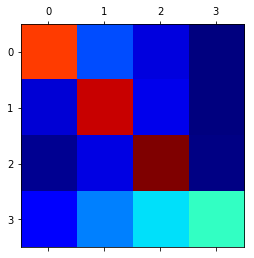

In [82]:
import matplotlib.pyplot as plt
plt.matshow(cm, cmap=plt.cm.jet)
plt.show()

In [83]:
# Predict the result on some short new sentences:
sentences = [
    u'lovely definition: 1. pleasant or enjoyable: 2. beautiful:',
    u'Hate speech is a communication that carries no meaning other than the expression of hatred for some group',
    u'amazing wow love this!!!',
]
predicted = clf.predict(sentences)

In [84]:
print(predicted)

[0 3 0]


In [85]:
strList = ['Biological life cycle - WikipediaIn biology, a biological life cycle is a series of changes in form that an organism \nundergoes, returning to the starting state. "The concept is closely related to those\n\xa0...',
 'Life Itself (2018 film) - WikipediaLife Itself is a 2018 American drama film written and directed by Dan Fogelman. It \nstars Oscar Isaac, Olivia Wilde, Mandy Patinkin, Olivia Cooke, Laia Costa,\xa0...',
 'Everyday life - WikipediaEveryday life, daily life or routine life comprises the ways in which people \ntypically act, think, and feel on a daily basis. Everyday life may be described as\xa0...',
 'List of life sciences - WikipediaThe life sciences or biological sciences comprise the branches of science that \ninvolve the scientific study of life and organisms – such as microorganisms, \nplants,\xa0...',
 'Quality of life - WikipediaQuality of life (QOL) is the general well-being of individuals and societies, \noutlining negative and positive features of life. It observes life satisfaction, \nincluding\xa0...',
 'Life (The Cardigans album) - WikipediaLife is the second studio album of The Cardigans. It was released worldwide in \n1995 and was an international success, especially in Japan, where it achieved\xa0...',
 'The Book of Life (Harkness novel) - WikipediaThe Book of Life is a 2014 fantasy novel by American scholar Deborah Harkness, \nthe third book in the All Souls trilogy. As the sequel to the 2012 bestseller,\xa0...',
 'Life imprisonment - WikipediaLife imprisonment is any sentence of imprisonment for a crime under which \nconvicted persons are to remain in prison either for the rest of their natural life or \nuntil\xa0...',
 'Life (Keith Richards) - WikipediaLife is a memoir by the Rolling Stones guitarist Keith Richards, written with the \nassistance of journalist James Fox. Published in October 2010, in hardback, \naudio\xa0...',
 'The Game of Life - WikipediaThe Game of Life, also known simply as Life, is a board game originally created \nin 1860 by Milton Bradley, as The Checkered Game of Life. The Game of Life\xa0...']

In [87]:
predicted = clf.predict(strList)
print(predicted)

[2 1 1 2 1 1 1 2 1 2]


In [90]:
# save model
fullfile = os.path.expanduser("~/Dropbox/insight_side/"+'clf_0925.p')
with open(fullfile, 'wb') as fp:
    pickle.dump(clf, fp)